In [1]:
%load_ext autoreload
%autoreload 2

from src.models.beacon_model import BeaconModel
from src.data.datasets import FloorDataset
from src.utils import object_to_markdown
from src.plotting import plot_traces, plot_wifi, plot_beacons

from IPython.display import display

import seaborn as sns
import matplotlib.pyplot as plt
import torch

site_id = "5a0546857ecc773753327266"
floor_id = "B1"

floor_data = FloorDataset(
        site_id, 
        floor_id, 
        wifi_threshold=200, 
        sampling_interval=100, 
        include_wifi=True, 
        include_beacon=True,        
        validation_percent=None,
        test_percent=0.15
        )

floor_data_full = FloorDataset(
        site_id, 
        floor_id, 
        wifi_threshold=200, 
        sampling_interval=100, 
        include_wifi=True, 
        include_beacon=True,        
        )

floor_image = floor_data.image
floor_height = floor_data.info["map_info"]["height"]
floor_width = floor_data.info["map_info"]["width"]
sns.set(style="whitegrid")

train_indices = (~floor_data.test_mask & ~floor_data.validation_mask).nonzero().flatten()
test_indices = floor_data.test_mask.nonzero().flatten()

mini_batch_train = floor_data_full[train_indices[1:17:2]]
mini_batch_test = floor_data_full[test_indices[:8]]

# Beacon Model

In this notebook, we are implementing the iBeacon readings from the trace data. We are using the distance estimates provided by the beacons as is.

There aren't as many beacons as there are wifis, however they supposedly have shorter range, possibly making them more powerful for positioning.

From the exploratory analysis, we saw that the beacon estimates may not be enterily accurate, however we will be modelling this uncertainty using the bayesian modelling framework. This approach simplifies the model a bit, since we only need to estimate a position for each beacon for the variational posterior.

The model can be seen implemented as `BeaconModel` in `src/models/beacon_model.py`. The generative model is printed below:

In [2]:
display(object_to_markdown(BeaconModel.model))

```python
def model(
    self,
    mini_batch_index,
    mini_batch_length,
    mini_batch_time,
    mini_batch_position,
    mini_batch_position_mask,
    mini_batch_wifi,
    mini_batch_wifi_mask,
    mini_batch_beacon,
    mini_batch_beacon_mask,
    annealing_factor=1.0,
):

    pyro.module("beacon_model", self)

    T_max = mini_batch_time.shape[-1]
    K = self.K
    B = self.B

    relaxed_floor_dist = dist.Normal(
        self.floor_uniform.mean, self.floor_uniform.stddev
    ).to_event(1)

    sigma_eps = torch.tensor(self.prior_params["sigma_eps"], device=device)
    sigma = torch.tensor(self.prior_params["sigma"], device=device)
    mu_omega_0 = torch.tensor(self.prior_params["mu_omega_0"], device=device)
    sigma_omega_0 = torch.tensor(self.prior_params["sigma_omega_0"], device=device)
    sigma_omega = torch.tensor(self.prior_params["sigma_omega"], device=device)
    sigma_delta = torch.tensor(self.prior_params["sigma_delta"], device=device)

    with poutine.scale(None, annealing_factor):

        with pyro.plate("mini_batch", len(mini_batch_index)):

            x_0 = sample("x_0", relaxed_floor_dist)
            x = torch.zeros(
                x_0.shape[:-1] + (T_max,) + x_0.shape[-1:],  # Batch dims, time, x/y
                dtype=mini_batch_position.dtype,
                device=device,
            )
            x[..., 0, :] = x_0

            for t in pyro.markov(range(1, T_max)):
                x[..., t, :] = sample(
                    f"x_{t}",
                    dist.Normal(x[..., t - 1, :], sigma_eps)
                    .to_event(1)
                    .mask(t < mini_batch_length),
                )

    with pyro.plate("x_observed", mini_batch_position_mask.sum()):
        sample(
            "x_hat",
            dist.Normal(x[..., mini_batch_position_mask, :], sigma).to_event(1),
            obs=mini_batch_position[mini_batch_position_mask],
        )

    any_wifi_is_observed = mini_batch_wifi_mask.any(dim=-1)

    with plate("wifis", K):

        with poutine.scale(None, annealing_factor):
            omega_0 = sample("omega_0", dist.Normal(mu_omega_0, sigma_omega_0))
            wifi_location = sample("wifi_location", relaxed_floor_dist)

        distance = torch.cdist(x[..., any_wifi_is_observed, :], wifi_location)
        with plate("wifi_is_observed", any_wifi_is_observed.sum()):
            signal_strength = omega_0 - 2 * torch.log(distance)
            omega = sample(
                "omega",
                dist.Normal(signal_strength, sigma_omega).mask(
                    mini_batch_wifi_mask[any_wifi_is_observed]
                ),
                obs=mini_batch_wifi[any_wifi_is_observed],
            )

    any_beacon_is_observed = mini_batch_beacon_mask.any(dim=-1)

    with plate("beacons", B):

        with poutine.scale(None, annealing_factor):
            beacon_location = sample("beacon_location", relaxed_floor_dist)

        distance = torch.cdist(x[..., any_beacon_is_observed, :], beacon_location)
        with plate("beacon_is_observed", any_beacon_is_observed.sum()):
            # Probably not the most suitable distribution
            delta = sample(
                "delta",
                dist.Normal(distance, sigma_delta).mask(
                    mini_batch_beacon_mask[any_beacon_is_observed]
                ),
                obs=mini_batch_beacon[any_beacon_is_observed],
            )

    return x, wifi_location, beacon_location
```

In [3]:
torch.manual_seed(123)
beacon_model = BeaconModel(floor_data)

Like the wifi model, the location of the beacons is also simply a gaussian distribution covering the floor area. We may sample them such positions from the prior:

In [4]:
x, wifi_location, beacon_location = beacon_model.model(*mini_batch_train)

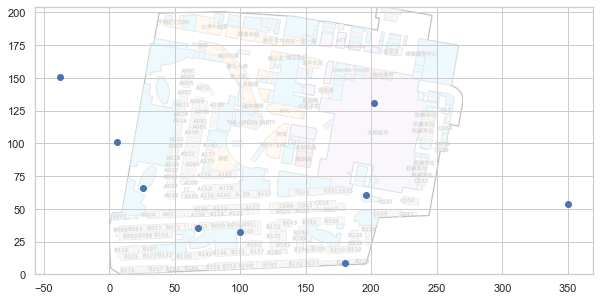

In [5]:
plt.figure(figsize=(10,8))
plt.imshow(floor_image, extent=(0, floor_width, 0, floor_height), alpha=0.3)
plt.scatter(*beacon_location.T)
plt.show()

As for the guide function, the beacon positions are included using a mean field approximation with diagonal variance. The remaining part of the guide function remains the same.

In [6]:
object_to_markdown(BeaconModel.guide)

```python
def guide(
    self,
    mini_batch_index,
    mini_batch_length,
    mini_batch_time,
    mini_batch_position,
    mini_batch_position_mask,
    mini_batch_wifi,
    mini_batch_wifi_mask,
    mini_batch_beacon,
    mini_batch_beacon_mask,
    annealing_factor=1.0,
):

    pyro.module("beacon_model", self)

    T_max = mini_batch_time.shape[-1]
    K = self.K
    B = self.B

    location = torch.zeros((len(mini_batch_index), T_max, 2), device=device)
    scale = torch.zeros((len(mini_batch_index),), device=device)

    for i, (index, length) in enumerate(zip(mini_batch_index, mini_batch_length)):
        l, s = self.trace_guides[index](mini_batch_time[i, :length].unsqueeze(1))
        location[i, :length, :] = l
        scale[i] = s

    with poutine.scale(None, annealing_factor):

        with pyro.plate("mini_batch", len(mini_batch_index)):

            for t in pyro.markov(range(0, T_max)):
                sample(
                    f"x_{t}",
                    dist.Normal(location[:, t, :], scale.view(-1, 1))
                    .to_event(1)
                    .mask(t < mini_batch_length),
                )

        with plate("wifis", K):
            sample("omega_0", dist.Normal(self.mu_q, self.log_sigma_q.exp()))
            sample(
                "wifi_location",
                dist.Normal(
                    self.wifi_location_q, self.wifi_location_log_sigma_q.exp()
                ).to_event(1),
            )

        with plate("beacons", B):
            sample(
                "beacon_location",
                dist.Normal(
                    self.beacon_location_q, self.beacon_location_log_sigma_q.exp()
                ).to_event(1),
            )

    return location, scale
```

## Model Training
As with the other models, we used hyperparameter search using `optuna` in order to figure out reasonable choices for optimization algorithm, learning rate etc. Below we present the results from the best trial. First, the model is restored from checkpoint

In [7]:
from src.utils import get_study
best_index = get_study("beacon").best_trial.number
checkpoint = torch.load(f"../checkpoints/beacon_hparam_{best_index:03}.pt", map_location="cpu")
beacon_model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

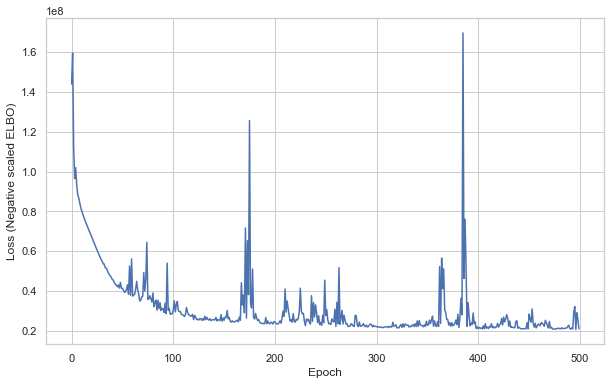

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(checkpoint["loss_history"])
plt.xlabel("Epoch")
plt.ylabel("Loss (Negative scaled ELBO)")
plt.show()

Below, we plot the aproximate posteriors of some of trace curves that were included in the training set.

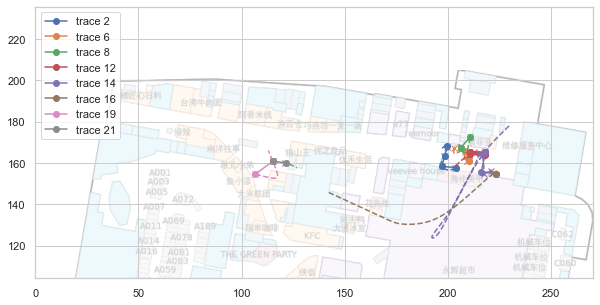

In [9]:
plt.figure(figsize=(10, 5))
plt.imshow(floor_image, extent=(0, floor_width, 0, floor_height), alpha=0.3)
plot_traces(beacon_model, mini_batch_train)
plt.axis("equal");
plt.ylim((140, 200))
plt.legend()

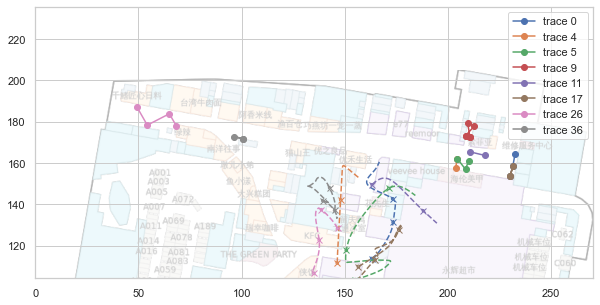

In [10]:
plt.figure(figsize=(10, 5))
plt.imshow(floor_image, extent=(0, floor_width, 0, floor_height), alpha=0.3)
plot_traces(beacon_model, mini_batch_test)
plt.axis("equal");
plt.ylim((140, 200))

plt.legend()
plt.show()

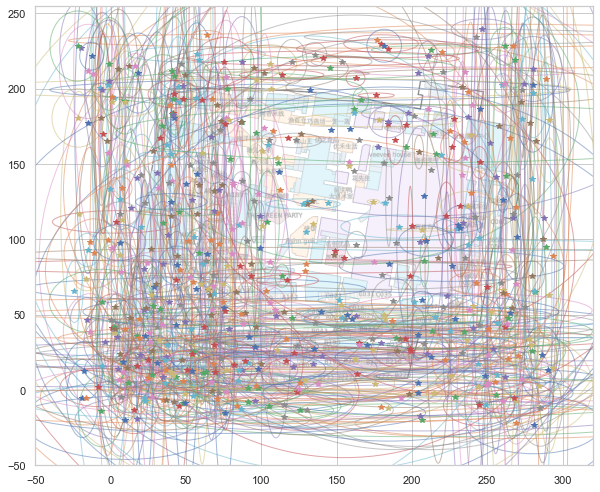

In [11]:
plt.figure(figsize=(10, 10))
plt.imshow(floor_image, extent=(0, floor_width, 0, floor_height), alpha=0.5)
plot_wifi(beacon_model)
plt.xlim(-50, floor_width + 50)
plt.ylim(-50, floor_height + 50)
plt.show()

In [12]:
from src.plotting import get_wifi_strengths

wifi_indices = [0, 1, 2, 3, 4, 5]
wifi_bssids = [floor_data.bssids_[i] for i in wifi_indices]
wifi_strengths = get_wifi_strengths(floor_data, wifi_bssids)

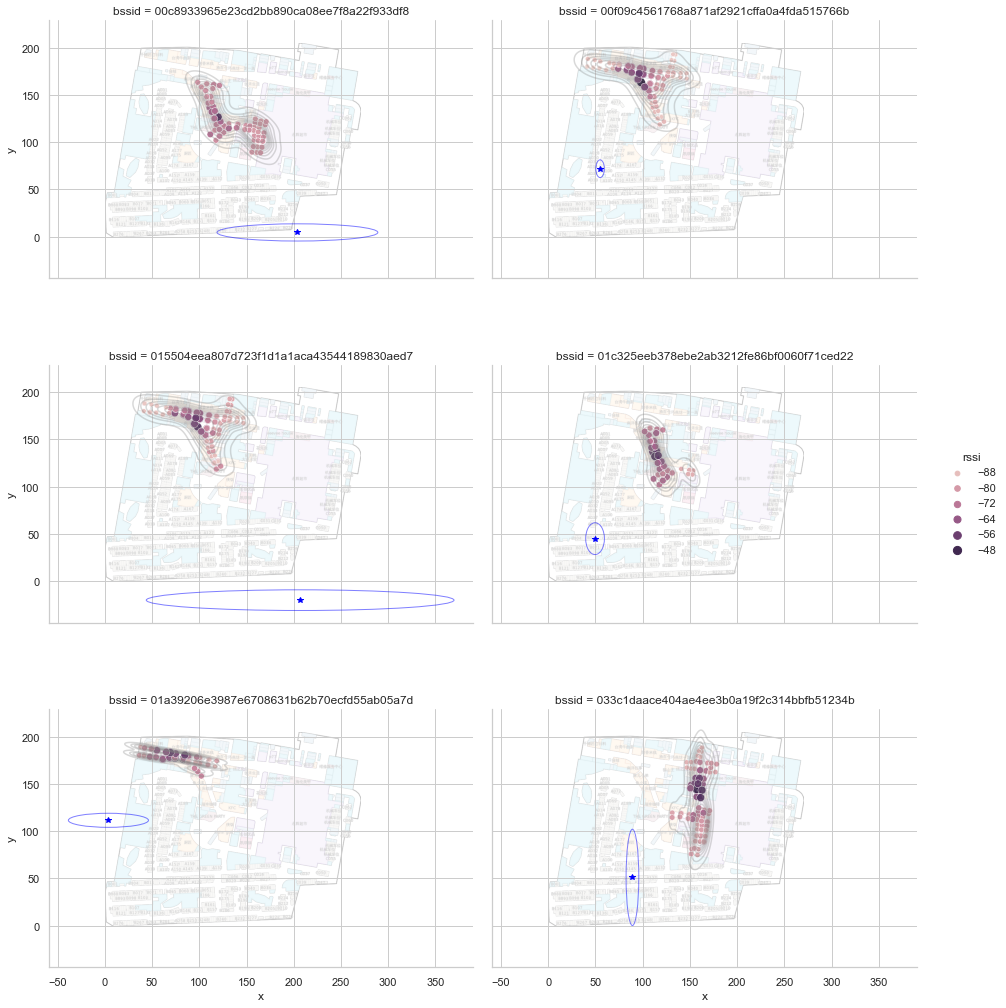

In [13]:
fg = sns.relplot(data=wifi_strengths, x="x", y="y", col="bssid", col_wrap=2, hue="rssi", size='rssi', aspect=floor_width/floor_height)
fg.map_dataframe(sns.kdeplot, "x", "y", color="grey", alpha=0.3)
for bssid, ax in fg.axes_dict.items():
    ax.imshow(floor_data.image, extent=(0, floor_width, 0, floor_height), alpha=0.3)
    plot_wifi(beacon_model, [wifi_bssids.index(bssid)], ax=ax, color="blue")

In [14]:
from src.plotting import get_beacon_distances

In [15]:
beacon_distances  = get_beacon_distances(floor_data, floor_data.beacon_ids_)
beacon_uuids = floor_data.beacon_ids_

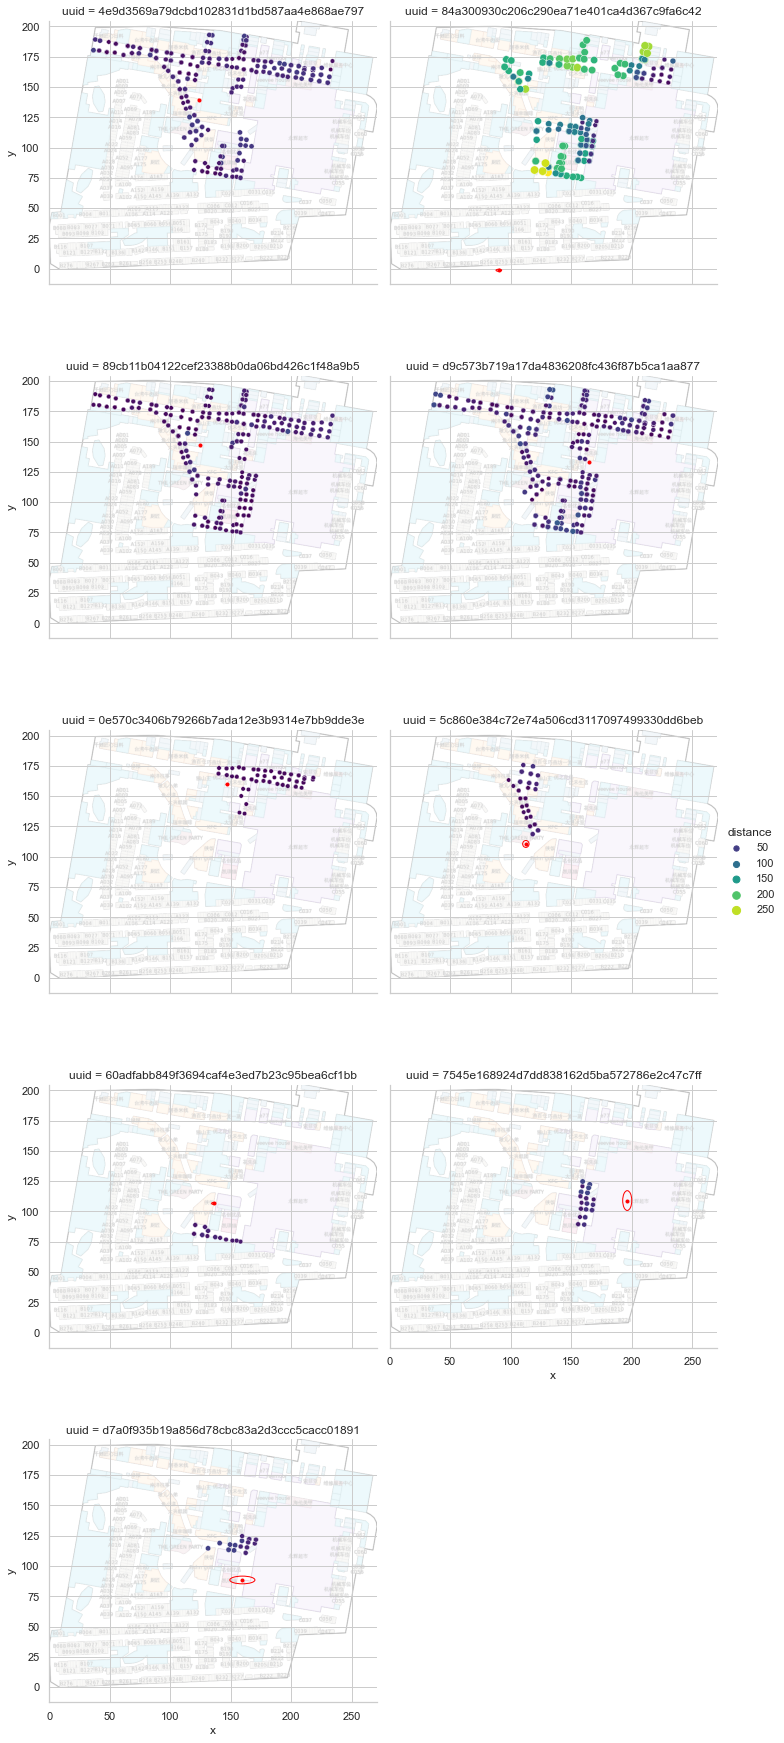

In [16]:
fg = sns.relplot(data=beacon_distances, x="x", y="y", size="distance", hue="distance", col="uuid", col_wrap=2, palette="viridis")
for uuid, ax in fg.axes_dict.items():
    ax.imshow(floor_data.image, extent=(0, floor_width, 0, floor_height), alpha=0.3)
    plot_beacons(beacon_model, [beacon_uuids.index(uuid)], ax=ax, color="red")